Multivariate pattern analysis (MVPA)
===

# 0 Setup

In [1]:
import os
import numpy as np
from scipy.signal import detrend
from scipy.stats import zscore
from scipy.ndimage import binary_dilation
from matplotlib.pyplot import plot

import nibabel as nb
from nilearn import plotting
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.maskers import NiftiMasker
from nilearn.decoding import SearchLight
from nilearn.decoding import SpaceNetClassifier

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score


fslpath = os.environ["FSLDIR"]

anat_template = os.path.join(fslpath, "data/standard/MNI152_T1_2mm_brain.nii.gz")
os.path.exists(anat_template)

True

# 1 Preparation

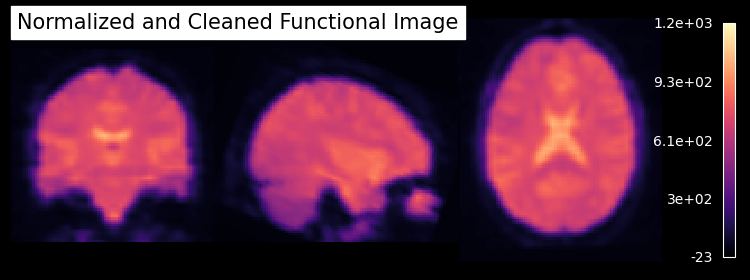

In [2]:
input_file = "../individual/output/datasink/preproc_wf/sub-02/task-flanker/sub-02_task-flanker_run-1_bold_warp.nii"

img_func = nb.load(input_file)
plotting.plot_anat(img_func.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', vmax=1250, cut_coords=[33, -20, 20], colorbar=True,
          title='Normalized and Cleaned Functional Image')

## 1.1 Signal time-course of a voxel 

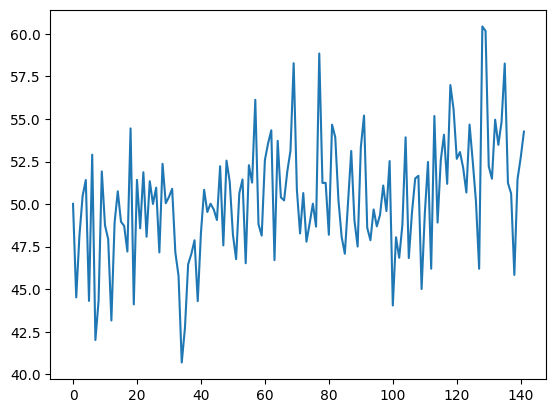

In [3]:
plot(img_func.get_fdata()[19, 16, 17, :])

To be able to do some machine learning on this data we therefore need to remove the linear trend and ideally zscore the data.

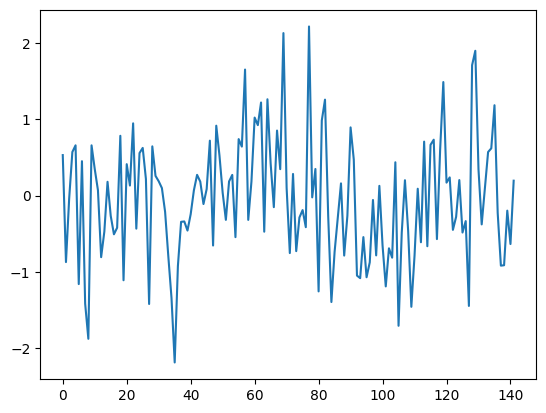

In [4]:
# Detrend and zscore the data
data = img_func.get_fdata()
data = detrend(data)
data = np.nan_to_num(zscore(data, axis=0))

# Plot the cleaned signal
plot(data[19, 16, 17, :]);

## 1.2 How many nonzero voxels do we have?

 It doesn’t make sense that we run machine learning outside of the brain.

In [5]:
img_func.get_fdata().shape

(91, 109, 91, 142)

In [6]:
np.sum(img_func.get_fdata().mean(axis=-1)!=0)

777362

So let’s use a mask to only keep those voxels that we’re interested in. For this purpose we will use the MNI-152 template brain mask and an eye mask.

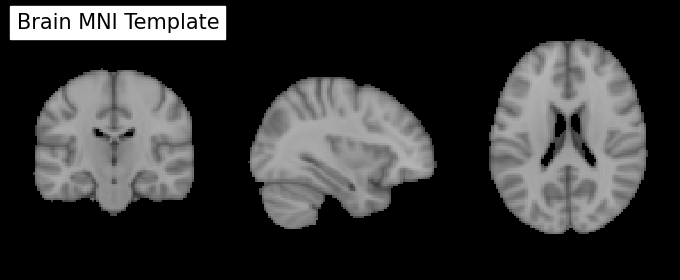

In [7]:
# Plot the region-of-interest (ROI) template
plotting.plot_anat(anat_template, dim='auto', draw_cross=False, annotate=False,
          cut_coords=[33, -20, 20], title='Brain MNI Template')

Great, now we just need to binarize this template to get a mask, dilate this mask a bit to be sure that we keep all relevant voxels and multiply it with the functional image. But before we can do any of this we also need to resample the ROI template to the same voxel resolution as the functional images.

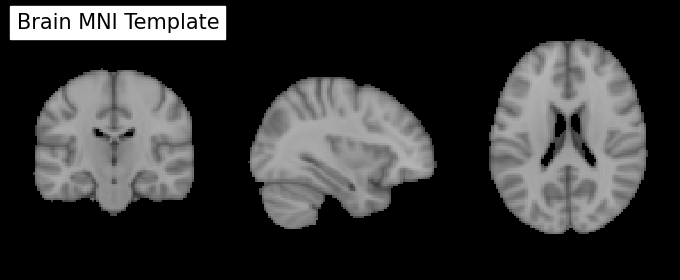

In [8]:
# Resample ROI template to functional image resolution

img_resampled = image.resample_to_img(anat_template, img_func)

plotting.plot_anat(img_resampled, dim='auto', draw_cross=False, annotate=False,
          cut_coords=[33, -20, 20], title='Brain MNI Template')

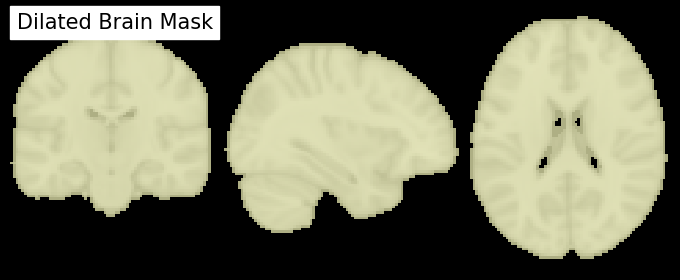

In [9]:
# Binarize ROI template
data_binary = np.array(img_resampled.get_fdata()>=10, dtype=np.int8)

# Dilate binary mask once
data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)

# Save binary mask in NIfTI image
img_mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
img_mask.set_data_dtype('i1')

# Plot binary mask (overlayed over MNI-152_Template)
plotting.plot_roi(img_mask, draw_cross=False, annotate=False, black_bg=True,
         bg_img=anat_template, cut_coords=[33, -20, 20],
         title='Dilated Brain Mask', cmap='magma_r', dim=1)

Cool. How many voxels do we have now?

In [10]:
np.sum(img_mask.get_fdata())

247661.0

Before

In [11]:
np.sum(img_func.get_fdata().mean(axis=-1)!=0)

777362

In [12]:
247661.0/777362

0.31859159567871853

That's a 69% reduction of datapoints that we need to consider in our machine-learning approach!

Now we only have to multiply this mask with our functional images and remove tailing zeros from the 3D matrix.

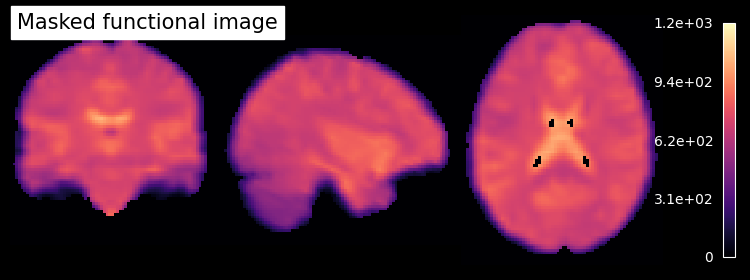

In [13]:
# Multiply the functional image with the mask
img_cleaned = image.math_img('img1 * img2', img1=img_func, img2=img_mask.slicer[..., None])

# Remove as many zero rows in the data matrix to reduce overall volume size
img_crop = image.crop_img(img_cleaned)
 
plotting.plot_anat(img_crop.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', vmax=1250, cut_coords=[33, -20, 20], colorbar=True,
          title='Masked functional image')

## 1.3 All the above in one go

In [14]:
# Load functional image
img_func = nb.load(input_file)

# Detrend and zscore data and save it under a new NIfTI file
data = img_func.get_fdata()
data = detrend(data)
data = np.nan_to_num(zscore(data, axis=0))
img_standardized = nb.Nifti1Image(data, img_func.affine, img_func.header)

img_resampled = image.resample_to_img(anat_template, img_func)
data_binary = np.array(img_resampled.get_fdata()>=10, dtype=np.int8)
data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)
img_mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
img_mask.set_data_dtype('i1')

# Multiply functional image with mask and crop image
img_cleaned = image.math_img('img1 * img2',
                       img1=img_standardized, img2=img_mask.slicer[..., None])
img_crop = image.crop_img(img_cleaned)

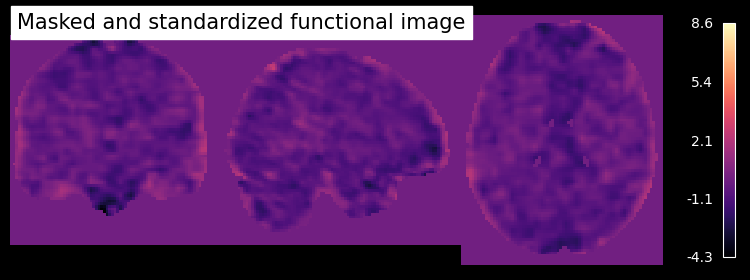

In [15]:
plotting.plot_anat(img_crop.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', cut_coords=[33, -20, 20], colorbar=True,
          title='Masked and standardized functional image')

## 1.4 Creating the machine learning dataset

Above we showed you how to prepare the data of an individual run for machine-learning. We now could use the 100 volumes per run and try to do machine learning on this. But this might not be the best approach.

Let’s consider again what we want to do. We want to predict if a person has their eyes closed or open during a resting state scan. Our assumption is that during the eyes open there is more eye movement, more visual stimulation, i.e. more variance in certain regions. Therefore, we want to look at the standard deviation over time (i.e. over the 100 volumes per run).

Keep in mind that this approach is more or less “randomly” chosen by us to be appropriate for this particular classification and might differ a lot to other datasets, research questions etc.

To nonetheless keep enough data points, let’s take the 100 volumes, and compute the standard deviation for 4 equally long sections:

In [16]:
img_std1 = nb.Nifti1Image(img_crop.get_fdata()[...,0:25].std(axis=-1), img_crop.affine, img_crop.header)
img_std2 = nb.Nifti1Image(img_crop.get_fdata()[...,25:50].std(axis=-1), img_crop.affine, img_crop.header)
img_std3 = nb.Nifti1Image(img_crop.get_fdata()[...,50:75].std(axis=-1), img_crop.affine, img_crop.header)
img_std4 = nb.Nifti1Image(img_crop.get_fdata()[...,75:100].std(axis=-1), img_crop.affine, img_crop.header)

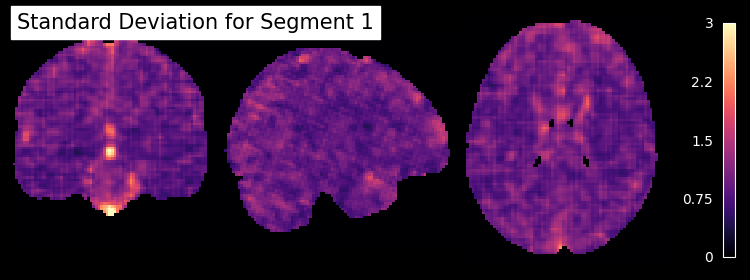

In [17]:
plotting.plot_anat(img_std1, draw_cross=False, annotate=False, cmap='magma',
          cut_coords=[33, -20, 20], vmax=3, colorbar=True,
          title='Standard Deviation for Segment 1')

If we do this now for each of the conditions run, for each of the n subjects in the dataset, we will get 4 segments x k conditions x n subjects = ___ datapoints per voxel. The pre-processing of all n subjects would explode the scope of this workshop, we therefore already pre-processed all subjects and prepared the data for the machine-learning approach: /home/neuro/workshop/notebooks/data/dataset_ML.nii.gz

# 2 MVPA

## 2.1 Using a ready-made ML dataset

In [18]:
func = 'dataset_ML.nii.gz'

if os.path.exists(func) == False:

    import urllib.request

    url = 'https://github.com/miykael/workshop_pybrain/raw/master/workshop/notebooks/data/dataset_ML.nii.gz'
    urllib.request.urlretrieve(url, 'dataset_ML.nii.gz')
    print("file downloaded")
    
else:
    print("file already available")

file downloaded


In [19]:
!nib-ls $func

dataset_ML.nii.gz float32 [ 40,  51,  41, 384] 4.00x4.00x4.00x1.00



## 2.2 Create mask

As we only want to use voxels in a particular region of interest (ROI) for the classification, let’s create a function that returns a mask that either contains the only the brain, only the eyes or both

In [20]:
def get_mask(func, template):
    
    img_resampled = image.resample_to_img(template, func)
 
    # Binarize ROI template
    data_binary = np.array(img_resampled.get_fdata()>=10, dtype=np.int8)

    # Dilate binary mask once
    data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)

    # Save binary mask in NIfTI image
    mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
    mask.set_data_dtype('i1')
    
    return mask

## 2.3 Masking and Un-masking data

For the classification with nilearn, we need our functional data in a 2D, sample-by-voxel matrix. To get that, we’ll select all the voxels defined in our mask.

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


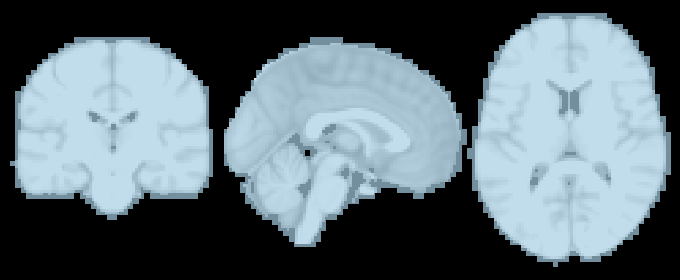

In [21]:
mask = get_mask(func, anat_template)
plotting.plot_roi(mask, anat_template, cmap='Paired', dim=-.5, draw_cross=False, annotate=False)

NiftiMasker is an object that applies a mask to a dataset and returns the masked voxels as a vector at each time point.

In [22]:
masker = NiftiMasker(mask_img=mask, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)
print(samples)

[[0.7965089  0.9749323  0.9000536  ... 0.56139576 0.40530768 0.71668595]
 [0.9088199  0.7303408  0.63435954 ... 0.80835986 0.44824055 0.46237826]
 [0.6761813  0.8293086  0.9835918  ... 0.5358669  0.56062424 0.72024435]
 ...
 [0.81860083 0.8177914  1.0595632  ... 0.63843036 0.5614186  0.7092098 ]
 [0.8739697  0.6019776  1.0053024  ... 0.5492817  0.67479044 0.70944095]
 [0.8174745  0.9999173  0.9347665  ... 0.6070517  0.92529875 0.7956351 ]]


Its shape corresponds to the number of time-points times the number of voxels in the mask.

In [23]:
print(samples.shape)

(384, 33243)


To recover the original data shape (giving us a masked and z-scored BOLD series), we simply use the masker’s inverse transform:

In [24]:
masked_epi = masker.inverse_transform(samples)

Let’s now visualize the masked epi.

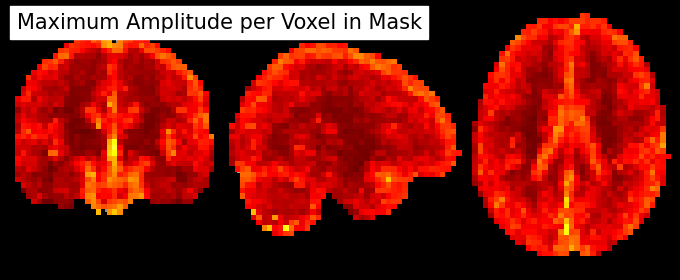

In [25]:
max_zscores = image.math_img("np.abs(img).max(axis=3)", img=masked_epi)
plotting.plot_stat_map(max_zscores, bg_img=anat_template, dim=-.5, cut_coords=[33, -20, 20],
              draw_cross=False, annotate=False, colorbar=False,
              title='Maximum Amplitude per Voxel in Mask')

## 2.4 Simple MVPA Example

Multi-voxel pattern analysis (MVPA) is a general term for techniques that contrast conditions over multiple voxels. It’s very common to use machine learning models to generate statistics of interest.

In this case, we’ll use the response patterns of voxels in the mask to predict if the eyes were closed or open during a resting-state fMRI recording. But before we can do MVPA, we still need to specify two important parameters:

First, we need to know the label for each volume. From the last section of the Machine Learning Preparation notebook, we know that we have a total of 384 volumes in our dataset_ML.nii.gz file and that it’s always 4 volumes of the condition eyes closed, followed by 4 volumes of the condition eyes open, etc. Therefore our labels should be as follows:

In [26]:
labels = np.ravel([[['closed'] * 4, ['open'] * 4] for i in range(48)])
labels[:20]

array(['closed', 'closed', 'closed', 'closed', 'open', 'open', 'open',
       'open', 'closed', 'closed', 'closed', 'closed', 'open', 'open',
       'open', 'open', 'closed', 'closed', 'closed', 'closed'],
      dtype='<U6')

Second, we need the chunks parameter. This variable is important if we want to do for example cross-validation. In our case we would ideally create 48 chunks, one for each subject. But because a cross-validation of 48 chunks takes very long, let’s just create 6 chunks, containing always 8 subjects, i.e. 64 volumes:

In [27]:
chunks = np.ravel([[i] * 64 for i in range(6)])
chunks[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

One way to do cross-validation is the so called Leave-one-out cross-validation. This approach trains on (n - 1) chunks, and classifies the remaining chunk, and repeats this for every chunk, also called fold. Therefore, a 6-fold cross-validation is one that divides the whole data into 6 different chunks.

Now that we have the labels and chunks ready, we’re only missing the classifier. In Scikit-Learn, there are many to choose from, let’s start with the most well known, a linear support vector classifier (SVC).

In [28]:
# Let's specify the classifier
clf = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=25)

Note: The number of maximum iterations should ideally be much much bigger (around 1000), but was kept low here to reduce computation time.

Now, we’re ready to train the classifier and do the cross-validation.

In [29]:
# Performe the cross validation (takes time to compute)
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceW

After the cross validation was computed we can extract the overall accuracy, as well as the accuracy for each individual fold (i.e. leave-one-out prediction). Mean (across subject) cross-validation accuracy is a common statistic for classification-based MVPA.

In [30]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 78.12 percent

Accuracy per fold:
[0.765625 0.765625 0.75     0.828125 0.84375  0.734375]


An average accuracy above 70%. What if we use another classifier? Let’s say a Gaussian Naive Bayes classifier?

In [31]:
# Let's specify a Gaussian Naive Bayes classifier
clf = GaussianNB()

cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=1,
                            verbose=1)



print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Average accuracy = 75.52 percent

Accuracy per fold:
[0.703125 0.703125 0.8125   0.765625 0.859375 0.6875  ]


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s finished


That was much quicker but less accurate. As was expected. What about a Logistic Regression classifier?

In [32]:
# Let's specify a Logistic Regression classifier
clf = LogisticRegression(penalty='l2', max_iter=25)

cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)

print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Average accuracy = 79.17 percent

Accuracy per fold:
[0.75     0.765625 0.75     0.84375  0.890625 0.75    ]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

The prediction accuracy is around 80%, much better! But anyhow, how do we know if an accuracy value is significant or not? Well, one way to find this out is to do some permutation testing.

## 2.5 Permutation testing

One way to test the quality of the prediction accuracy is to run the cross-validation multiple times, but permutate the labels of the volumes randomly. Afterward we can compare the accuracy value of the correct labels to the ones with the random / false labels. Luckily Scikit-learn already has a function that does this for us. So let’s do it.

Note: We chose again the GaussianNB classifier to reduce the computation time per cross-validation. Additionally, we chose the number of iterations under n_permutations for the permutation testing very low, to reduce computation time as well. This value should ideally be much higher, at least 100.

In [33]:
# Let's chose again the linear SVC
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Import the permuation function
from sklearn.model_selection import permutation_test_score

# Run the permuation cross-validation
null_cv_scores = permutation_test_score(estimator=clf,
                                        X=samples,
                                        y=labels,
                                        groups=chunks,
                                        cv=LeaveOneGroupOut(),
                                        n_permutations=25,
                                        n_jobs=-1,
                                        verbose=1)

print('Prediction accuracy: %.02f' % (null_cv_scores[0] * 100),
      'p-value: %.04f' % (null_cv_scores[2]),
      sep='\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction accuracy: 75.52
p-value: 0.0385


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    7.4s finished


Great! This means… Using resting-state fMRI images, we can predict if a person had their eyes open or closed with an accuracy significantly above chance level!

## 2.6 Which region is driving the classification?

With a simple MVPA approach, we unfortunately don’t know which regions are driving the classification accuracy. We just know that all voxels in the mask allow the classification of the two classes, but why? We need a better technique that tells us where in the head we should look.

There are many different ways to figure out which region is important for classification, but let us introduce you two different approaches that you can use in nilearn: SpaceNet and Searchlight

## 2.7 SpaceNet: decoding with spatial structure for better maps

SpaceNet implements spatial penalties which improve brain decoding power as well as decoder maps. The results are brain maps which are both sparse (i.e regression coefficients are zero everywhere, except at predictive voxels) and structured (blobby). For more detail, check out nilearn’s section about SpaceNet.

To train a SpaceNet on our data, let’s first split the data into a training set (chunk 0-4) and a test set (chunk 5).

In [34]:
# Create two masks that specify the training and the test set 
mask_test = chunks == 5
mask_train = np.invert(mask_test)


# Apply this sample mask to X (fMRI data) and y (behavioral labels)
from nilearn.image import index_img
X_train = index_img(func, mask_train)
y_train = labels[mask_train]

X_test = index_img(func, mask_test)
y_test = labels[mask_test]

Now we can fit the SpaceNet to our data with a TV-l1 penalty. Note again, that we reduced the number of max_iter to have a quick computation. In a realistic case this value should be around 1000.

In [35]:
# Fit model on train data and predict on test data
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=get_mask(func, anat_template),
                             max_iter=10,
                             cv=5,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 51, 41, 320),
affine=array([[  -4.,    0.,    0.,   78.],
       [   0.,    4.,    0., -114.],
       [   0.,    0.,    4.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/usr/local/lib/python3.10/dist-packages/nilearn/decoding/space_net.py:841: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  self.screening_percentile_ = _adjust_screening_percentile(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7fe88ce79d80>, loss='logistic'), array([[0.588454, ..., 0.029157],
       ...,
       [0.678369, ..., 2.213025]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 64, ..., 319]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), 
{'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=17.176952666726837)
_____________________________

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7fe88ce79d80>, loss='logistic'), array([[0.588454, ..., 0.029157],
       ...,
       [0.678369, ..., 2.213025]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 319]), array([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]), 
{'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1,

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.0s finished


SpaceNetClassifier(cv=5,
                   mask=<nibabel.nifti1.Nifti1Image object at 0x7fe8a5cd7190>,
                   max_iter=10, memory=Memory(location=nilearn_cache/joblib),
                   memory_level=2, penalty='tv-l1')

Now that the SpaceNet is fitted to the training data. Let’s see how well it does in predicting the test data.

In [36]:
# Predict the labels of the test data
y_pred = decoder.predict(X_test)

# Retrun average accuracy
accuracy = (y_pred == y_test).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 51, 41, 64),
affine=array([[  -4.,    0.,    0.,   78.],
       [   0.,    4.,    0., -114.],
       [   0.,    0.,    4.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals

TV-l1  classification accuracy : 73.4375%


Again accuracy around 75% prediction accuracy? But we wanted to know what’s driving this prediction. So let’s take a look at the fitting coefficients.

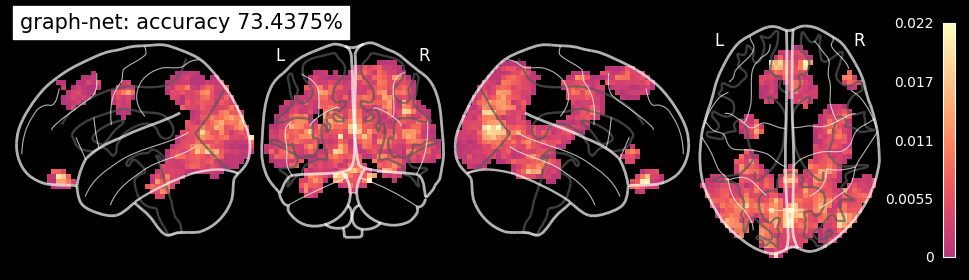

In [37]:
coef_img = decoder.coef_img_


# Plotting the searchlight results on the glass brain
plotting.plot_glass_brain(coef_img, black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title='graph-net: accuracy %g%%' % accuracy)

Cool! As expected the visual cortex (in the back of the head) and the eyes are driving the classification!

## 2.8 Searchlight

Now the next question is: How high would the prediction accuracy be if we only take one small region to do the classification?

To answer this question we can use something that is called a Searchlight approach. The searchlight approach was first proposed by Kriegeskorte et al., 2006. It is a widely used approach for the study of the fine-grained patterns of information in fMRI analysis. Its principle is relatively simple: a small group of neighboring features is extracted from the data, and the prediction function is instantiated on these features only. The resulting prediction accuracy is thus associated with all the features within the group, or only with the feature on the center. This yields a map of local fine-grained information, that can be used for assessing hypothesis on the local spatial layout of the neural code under investigation.

You can do a searchlight analysis in nilearn as follows:

In [38]:
# Specify the mask in which the searchlight should be performed
mask = get_mask(func, anat_template)

# Specify the classifier to use
# Let's use again a GaussainNB classifier to reduce computation time
clf = GaussianNB()

# Specify the radius of the searchlight sphere  that will scan the volume
# (the bigger the longer the computation)
sphere_radius = 8  # in mm


# Create searchlight object
sl = SearchLight(mask,
                 process_mask_img=mask,
                 radius=sphere_radius,
                 estimator=clf,
                 cv=LeaveOneGroupOut(),
                 n_jobs=-1,
                 verbose=1)


# Run the searchlight algorithm
sl.fit(nb.load(func), labels, groups=chunks)

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Job #1, processed 0/4156 voxels (0.00%, 168 seconds remaining)
Job #2, processed 0/4156 voxels (0.00%, 149 seconds remaining)
Job #6, processed 0/4155 voxels (0.00%, 216 seconds remaining)
Job #5, processed 0/4155 voxels (0.00%, 170 seconds remaining)
Job #4, processed 0/4155 voxels (0.00%, 151 seconds remaining)
Job #7, processed 0/4155 voxels (0.00%, 164 seconds remaining)
Job #8, processed 0/4155 voxels (0.00%, 139 seconds remaining)
Job #3, processed 0/4156 voxels (0.00%, 144 seconds remaining)
Job #1, processed 10/4156 voxels (0.24%, 65 seconds remaining)
Job #2, processed 10/4156 voxels (0.24%, 65 seconds remaining)
Job #6, processed 10/4155 voxels (0.24%, 65 seconds remaining)
Job #5, processed 10/4155 voxels (0.24%

SearchLight(cv=LeaveOneGroupOut(), estimator=GaussianNB(),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fe888c73070>,
            n_jobs=-1,
            process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fe888c73070>,
            radius=8, verbose=1)

That took a while. So let’s take a look at the results.

In [39]:
# First we need to put the searchlight output back into an MRI image
searchlight_img = image.new_img_like(func, sl.scores_)

Now we can plot the results. Let’s plot it once on the glass brain and once from the side. For better interpretation on where the peaks are, let’s set a minimum accuracy threshold of 60%.

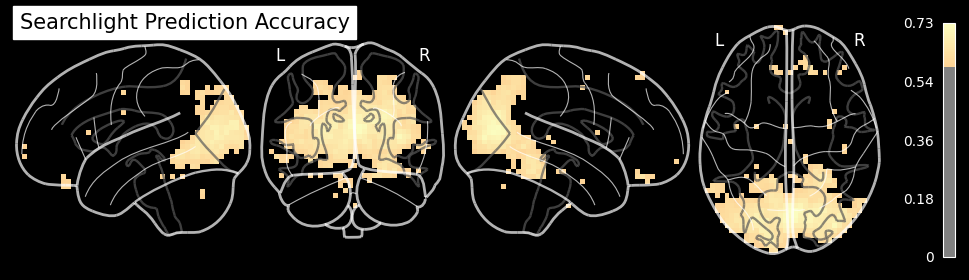

In [40]:
plotting.plot_glass_brain(searchlight_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.6, cmap='magma', title='Searchlight Prediction Accuracy')

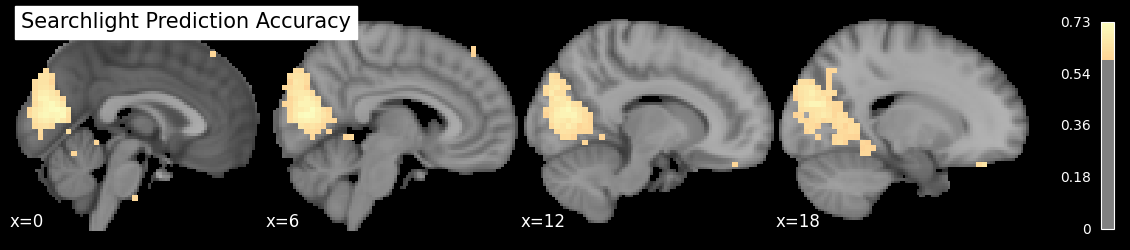

In [41]:
plotting.plot_stat_map(searchlight_img, cmap='magma', bg_img=anat_template, colorbar=True,
              display_mode='x', threshold=0.6, cut_coords=[0, 6, 12, 18],
              title='Searchlight Prediction Accuracy');

As expected and already seen before, the hotspots with high prediction accuracy are around the primary visual cortex (in the back of the head).